In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=2, suppress=True)

In [2]:
alpha = 0.01  # Q-function learning rate

# ppo params
eps = 0.5

# rbi params
cmin = 0.5
cmax = 1.5
# cgreed = 0

# tv params
delta = 0.25

# constant exploration
exp = 0.1

# rewards and their probabilities
mu_r = np.array([0, 1])
sigma_r = np.array([1, 10])

# provision for discrete reward distribution
# R =  [[1, 2],     [1, 2],     [-100, 100]]
# Rp = [[0.5, 0.5], [0.4, 0.6], [0.6, 0.4]]


In [3]:
def sim(pi):
    
    # provision for discrete reward distribution
    # r = np.random.choice(R[a], p=Rp[a])
    
    a = np.random.choice(len(pi), p=pi)
    r = np.random.randn() * sigma_r[a] + mu_r[a]
    
    return a, r

In [4]:
def tv(pi, A):

    a_len = len(pi)
    pi_prime = pi.copy()
    a = np.argmax(A)
    
    Delta = min(delta,  1 - pi[a])
    pi_prime[a] += Delta
    
    a_list = np.arange(a_len)
    while Delta > 0:
        
        index = np.argmin(A[a_list])
        a = a_list[index]
        
        Delta_a = min(Delta, pi_prime[a])
        a_list = np.delete(a_list, index)
        Delta = Delta - Delta_a
        pi_prime[a] -= Delta_a
    
    pi_prime = pi_prime / pi_prime.sum()
    
    return pi_prime

In [5]:
def greedy(pi, A):
    pi_greed = np.zeros_like(pi)
    pi_greed[np.argmax(A)] = 1
    return pi_greed
    

In [6]:
def rbi(pi, A):
    
    a_len = len(pi)
    
    Delta = 1 - cmin
    pi_prime = pi * cmin
    a_list = np.arange(a_len)
    
    while Delta > 0:
        
        index = np.argmax(A[a_list])
        a = a_list[index]
        Delta_a = min(Delta, (cmax - cmin) * pi[a])
        a_list = np.delete(a_list, index)
        Delta = Delta - Delta_a
        pi_prime[a] += Delta_a
    
#     pi_greed = np.zeros_like(pi)
#     pi_greed[np.argmax(A)] = 1
#     pi_prime = pi_prime * (1 - cgreed) + cgreed * pi_greed
    pi_prime = pi_prime / pi_prime.sum()
    
    return pi_prime

In [7]:
def ppo(pi, A):
    
    a_len = len(pi)
    
    Delta = 1
    pi_prime = np.zeros_like(pi)
    
    a_pos = np.arange(a_len)[A > 0]
    
    while Delta > 0 and len(a_pos):
        
        index = np.argmax(A[a_pos])
        a = a_pos[index]
        Delta_a = min(Delta, (1 + eps) * pi[a])
        a_pos = np.delete(a_pos, index)
        Delta = Delta - Delta_a
        pi_prime[a] += Delta_a
                
    a = np.argmax(A)
    pi_prime[a] += Delta
    
    pi_prime = pi_prime / pi_prime.sum()
    return pi_prime

In [8]:
def rl(algorithm, iterations, log=False):
    
    a_size = len(mu_r)
    
    q = np.random.randn(a_size) / 1000
    pi_rand = np.ones(a_size)
    pi_rand = pi_rand / pi_rand.sum()
    pi = pi_rand.copy()
    
    value = np.zeros(iterations)
    
    for i in range(iterations):
        
        beta = pi * (1 - exp) + exp * pi_rand
        a, r = sim(beta)
        q[a] = q[a] * (1 - alpha) + alpha * r
        
        v = (q * pi).sum()
        A = q - v
        
        if log:
            print("Policy: %s \t| a %d \t| r %d \t| Q-value %s \t| Advantage %s" % (str(pi), a, r, str(q), str(A)))
        
        pi = algorithm(pi, A)
        value[i] = (pi * mu_r).sum()
        
    return np.array(value), pi


rbi: 0.94
avg_pi: [0.03 0.97]
ppo: 0.74
avg_pi: [0.13 0.87]
tv: 0.65
avg_pi: [0.17 0.82]
greedy: 0.5
avg_pi: [0.25 0.75]


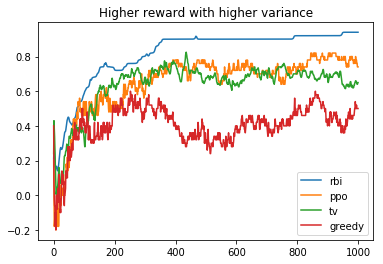

rbi: 1
avg_pi: [0. 1.]
ppo: 1
avg_pi: [0. 1.]
tv: 1
avg_pi: [0. 1.]
greedy: 1
avg_pi: [0. 1.]


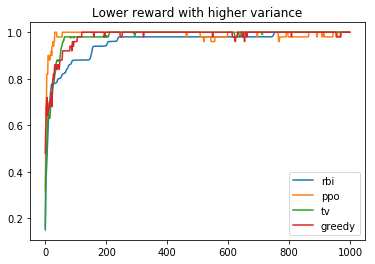

In [15]:
algorithms = {'rbi': rbi, 'ppo': ppo, 'tv': tv, 'greedy': greedy}
n_out = 100
n_in = 1000

# change these settings to evaluation rbi vs ppo vs tv vs greedy performance
mu_low = -1
mu_high = 1

sig_low = 1
sig_high = 12


# Type I: Higher reward with higher variance

# rewards and their probabilities
mu_r = np.array([mu_low, mu_high])
sigma_r = np.array([sig_low, sig_high])

for alg in algorithms:
    values = np.zeros((n_out, n_in))
    pis = np.zeros((n_out, len(mu_r)))
    
    for i in range(n_out):
        
        value, pi = rl(algorithms[alg], n_in)
        values[i] = value
        pis[i] = pi
        
    avg_vals = values.mean(axis=0)
    plt.plot(avg_vals, label=alg)
    print("%s: %g" % (alg, avg_vals[-1]))
    print("avg_pi: %s" % pis.mean(axis=0))
    
plt.legend()
plt.title("Higher reward with higher variance")
plt.show()
        
# Type II: Lower reward with higher variance

mu_r = np.array([mu_low, mu_high])
sigma_r = np.array([sig_high, sig_low])

for alg in algorithms:
    values = np.zeros((n_out, n_in))
    pis = np.zeros((n_out, len(mu_r)))
    
    for i in range(n_out):
        
        value, pi = rl(algorithms[alg], n_in)
        values[i] = value
        pis[i] = pi
        
    avg_vals = values.mean(axis=0)
    plt.plot(avg_vals, label=alg)
    print("%s: %g" % (alg, avg_vals[-1]))
    print("avg_pi: %s" % pis.mean(axis=0))
    
plt.legend()
plt.title("Lower reward with higher variance")
plt.show()
    